In [2]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
import requests

In [4]:
%%capture
%run -i -e main.ipynb

## Parameters
Select the parameters to apply for the pair selection


In [1]:
# Minimum correlation
min_corr = 0.9

# Max p-value to dismiss the h0-hypothesis in the cointegration test
pmax_coint = 0.05

# Max p-value to dismiss the h0-hypothesis in the augmented Dickey-Fuller test
pmax_adf = 0.05

# Max number of stock pairs to consider in the portfolio
max_quantity_pairs = 20

In [5]:
# Consider cluster from DBSCAN and consider train data for the pair selection
selected_clusters = pd.DataFrame(DBSCAN_cluster.copy())
train_data = data.copy()

In [6]:
# Filter the DataFrame based on the tickers in the specified cluster
selected_data = train_data[selected_clusters["Stock"]]

## Pair Validation
We check the identified clusters for stock pairs. In order to be considered as a pair, the following hypothese have to be met:   
    1. Correlation of stock price evolution of 95% or higher (and different to 1)  
    2. Check if the Cointegration hypothesis ho is dismissed  
    3. Check if the Augmented Dickey-Fuller hypothesis ho is dismissed 

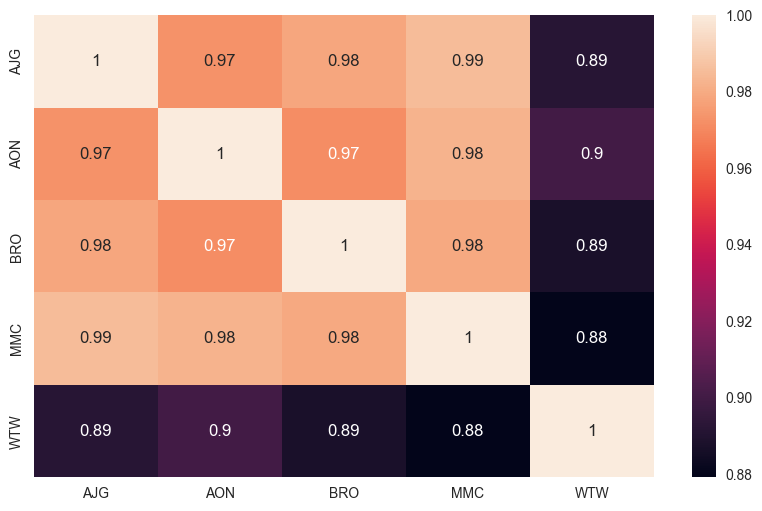

In [7]:
# Correlation test for the remaining stocks
corr = selected_data.corr()

# We investigate the correlation within a single cluster
cluster_to_investigate =2
cluster_stocks= selected_clusters[selected_clusters["Cluster"]==cluster_to_investigate]
plt.figure(figsize=(10, 6))
sns.heatmap(selected_data[cluster_stocks["Stock"]].corr(), annot=True)
plt.savefig(f'Correlation_Cluster_{cluster_to_investigate}.png',format='png', bbox_inches='tight')
plt.show()


In [8]:
#We also want to create a table giving us the KPIs of each pair
cluster_oversight =set()
for pair in combinations(selected_clusters.loc[selected_clusters["Cluster"] == cluster_to_investigate, "Stock"], 2):
        stock1, stock2 = pair
        # Correlation
        correlation = corr[stock1][stock2]
        #Cointegration
        coint = sm.tsa.coint(selected_data[stock1], selected_data[stock2])
        # Augmented Dickey-Fuller Test
        first_ADF = adfuller(selected_data[stock1])                             # Stationarity of stock 1
        second_ADF = adfuller(selected_data[stock2])                            # Stationarity of stock 2
        Spread_ADF = adfuller(selected_data[stock1] - selected_data[stock2])    # Stationarity of the spread between stock 1 and 2
        Ratio_ADF = adfuller(selected_data[stock1] / selected_data[stock2])     # Stationarity of the ratio of stock 1 and 2
        
        # We save the correlation as well as the p-values of the cointegration and the ADF
        cluster_oversight.add((stock1, stock2, correlation,coint[1],first_ADF[1],second_ADF[1],Spread_ADF[1],Ratio_ADF[1]))

cluster_oversight = pd.DataFrame(cluster_oversight, columns=["Stock 1","Stock 2","Correlation","Cointegration","ADF Stock 1","ADF Stock 2","ADF Spread","ADF Ratio"])
cluster_oversight.to_excel("ClusterOversight.xlsx", index = False)

In [10]:
# Now we apply our heuristics all clusters to identify all potential stock pairings
eligible_pairs_list = set()

for cluster in selected_clusters["Cluster"].unique():
    for pair in combinations(selected_clusters.loc[selected_clusters["Cluster"] == cluster, "Stock"], 2):
        # Find pair 
        stock1, stock2 = pair

        # Determine correlation value
        correlation = corr[stock1][stock2]
        
        # Check if Correlation is significant
        # Note: Dismiss correlation equal to 1 since this is realisticly only possible between the same stock
        if correlation > min_corr and correlation != 1:
            coint = sm.tsa.coint(selected_data[stock1], selected_data[stock2])
        
            # Check if the cointegration test is significant
            if coint[1] <= pmax_coint:

                # Augmented Dickey-Fuller Test
                first_ADF = adfuller(selected_data[stock1])                             # Stationarity of stock 1
                second_ADF = adfuller(selected_data[stock2])                            # Stationarity of stock 2
                Spread_ADF = adfuller(selected_data[stock1] - selected_data[stock2])    # Stationarity of the spread between stock 1 and 2
                Ratio_ADF = adfuller(selected_data[stock1] / selected_data[stock2])     # Stationarity of the ratio of stock 1 and 2

                # In the end we consider the ratio for our strategy, therefore we take the corresponding ADF test into account
                if Ratio_ADF[1] <= pmax_adf:
                    # Add pair to list
                    eligible_pairs_list.add((stock1, stock2, correlation,coint[1],Ratio_ADF[1]))

## Ranking potential pairs
We try to rank the remaining pairs now by the chance, that they are eligible for the pairs trading hypothesis. In order to make this ranking we consider following weight function:

$ Chance_{eligible} = (1-p_{coint}) *(1-p_{ADF})$

In [42]:
# Sort identified pairs by their test results
sorted_eligible_pairs = sorted(eligible_pairs_list, key=lambda x: (1-x[3])*(1-x[4]), reverse=True)

# Create a DataFrame to store informations
sorted_eligible_pairs_df = pd.DataFrame(sorted_eligible_pairs, columns=['Stock_1', 'Stock_2', 'Correlation', 'Cointegration','Ratio_ADF'])

# In case of too many pairs we select n pairs to our convenience
selected_pairs = sorted_eligible_pairs[:max_quantity_pairs]

# Print the selected pairs
print("\nA total of "+str(len(sorted_eligible_pairs))+" pairs have been found.")
print(f"A total of {len(selected_pairs)} were selected.")
sorted_eligible_pairs_df[:max_quantity_pairs]



A total of 23 pairs have been found.
A total of 20 were selected.


,Stock_1,Stock_2,Correlation,Cointegration,Ratio_ADF
0,DTE,PEG,0.977003,0.001020,0.001599
1,AEP,SRE,0.950195,0.007121,0.000680
2,BAC,PNC,0.986241,0.011029,0.002387
3,CFG,KEY,0.985417,0.010640,0.004934
4,AME,PH,0.970831,0.009924,0.012594
5,CMS,D,0.944158,0.001789,0.029211
6,CL,VRSK,0.876646,0.027304,0.005947
7,HON,IEX,0.956331,0.031355,0.002999
8,PRU,ZION,0.943534,0.030605,0.004906
9,EQR,ESS,0.984017,0.030371,0.005779


## Pair Visualization
We reeintroduce the visualization through TSNE in order to inspect the chosen pairs.  
Note that the visualization in 2D thorugh TSNE might not reflect the conclusion that DBSCAN or the hypothesis tests  have made before

In [17]:
#Build DataFrame which collects all TSNE results from concerned stocks
tsne_selected = []
for x,y in ([row[0],row[1]] for row in selected_pairs):
    tsne_selected.append([x,tsne_result[ret_T.index.get_loc(x),0],tsne_result[ret_T.index.get_loc(x),1]])
    tsne_selected.append([y,tsne_result[ret_T.index.get_loc(y),0],tsne_result[ret_T.index.get_loc(y),1]])

# Convert the list to a set to get unique elements based on the first element of each sub-list
tsne_selected = {tuple(row) for row in tsne_selected}
tsne_selected = list(tsne_selected)
tsne_selected = pd.DataFrame(tsne_selected, columns =["Stock","x","y"])

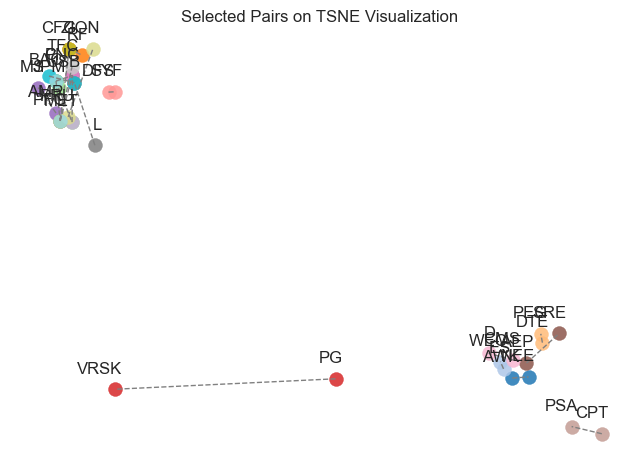

In [24]:
# Define a color map
color_map = cm.get_cmap('tab20')

# Connect datapoints with lines based on top_10_pairs
for index,pair in enumerate(selected_pairs):
    x1, y1 = tsne_selected.loc[tsne_selected["Stock"] == pair[0], ["x", "y"]].values.flatten()
    x2, y2 = tsne_selected.loc[tsne_selected["Stock"] == pair[1], ["x", "y"]].values.flatten()

    color = color_map(index / len(selected_pairs))
    plt.scatter(x1, y1, s=100, alpha=0.85, label="Stocks", color=color)
    plt.scatter(x2, y2, s=100, alpha=0.85, label="Stocks", color=color)
    plt.plot([x1, x2], [y1, y2], color="grey", linestyle='--', linewidth=1)

# Annotate each point with its label
for index, row in tsne_selected.iterrows():
    plt.annotate(row["Stock"], (row["x"], row["y"]+1), textcoords="offset points", xytext=(5,5), ha='right')

# Customize the plot as needed
plt.title('Selected Pairs on TSNE Visualization')
plt.axis("off")

# Show the plot
plt.show()
